In [109]:
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from RENT2 import RENT, stability
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import RepeatedKFold

import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [89]:
# accessing the dataframes we already made in the second approach
X_new = pd.read_pickle("X_new.pkl") 
X_2_new = pd.read_pickle("X_2_new.pkl")

# Feature selection based on the third approach

Referring to the thesis, chapter 5.2.4, RENT selects features based on this approach and the results are mentioned in this file.

## First block

### Removing samples caused noise

In [90]:
X_uten_bad_samples = X_new
X_uten_bad_samples = X_uten_bad_samples.drop(index=[42,43,21]) # These three sample caused so much noise
X_uten_bad_samples.set_index(pd.Series(range(0,X_uten_bad_samples.shape[0])), inplace = True)

In [91]:
y_uten_bad_samples = X_uten_bad_samples.loc[:,'y']
X_uten_bad_samples = X_uten_bad_samples.loc[:, X_uten_bad_samples.columns != 'y']

In [92]:
X_uten_bad_samples.shape

(68, 62)

### Removing some of the features based on the experts' suggetsions

In [93]:
first_block = X_uten_bad_samples.drop(['SMOKHAB_Unknown','MORPH_NA (Not Applicable)', 'MORPH_Other',
                                      'CGA1_Not Done','OCTREO_Not Done','SYNAPTOF_Not Done'], axis=1)

In [107]:
first_block.shape

(68, 56)

## Second block

### Removing samples caused noise

In [94]:
X_2_uten_bad_samples = X_2_new
X_2_uten_bad_samples = X_2_uten_bad_samples.drop(index=[42,43,21]) # These three sample caused so much noise
X_2_uten_bad_samples.set_index(pd.Series(range(0,X_2_uten_bad_samples.shape[0])), inplace = True)

In [95]:
X_2_uten_bad_samples = X_2_uten_bad_samples.loc[:, X_2_uten_bad_samples.columns != 'y']

In [96]:
X_2_uten_bad_samples.shape

(68, 27)

### Removing some of the features based on the experts' suggetsions

In [105]:
second_block = X_2_uten_bad_samples.drop(['HIAA_Not Done','CGA2_Not Done','HMGLBN_Not Done',
                                         'LACTDHDR_Not Done','PLATELTS_Not Done','WHITEBLD_Not Done',
                                         'TUMMARK1'], axis=1)

In [106]:
second_block.shape

(68, 20)

## Making new transformed target

<AxesSubplot:>

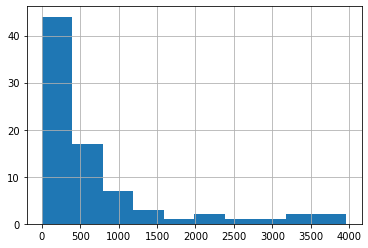

In [98]:
y.hist()# Distribution of the target itself

In [100]:
# Box-Cox to normalize
boxcox_y , something = ss.boxcox(y_uten_bad_samples)

<function matplotlib.pyplot.show(close=None, block=None)>

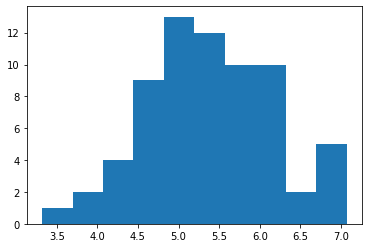

In [102]:
plt.hist(boxcox_y) # Distribution of transformed y
plt.show

## Running RENT on new blocks and target

### RENT feature selection on the first block

data dimension: (51, 56)  data type: <class 'pandas.core.frame.DataFrame'>
target dimension: (51,)
regularization parameters C: [0.1, 0.3, 0.5, 0.7, 1, 10]
elastic net l1_ratios: [0, 0.5, 1]
poly: OFF
number of models in ensemble: 700
random state: 0
verbose: 1
SELECTED FAETURES ARE : Index(['SURGMET', 'CGA1_Negative', 'RESPONS1_Complete Response (CR)',
       'RESPONS1_Progressive Disease (PD)', 'TIMETOTRM1'],
      dtype='object')
R2:  0.33928276342781294
RMSEP:  0.5500808682079457
mean VS1 -0.2306137994584402
VS1: p-value for average score from random feature drawing:  3.819087835035255e-24
VS1: heuristic p-value (how many scores are higher than the RENT score):  0.05
With a significancelevel of  0.05  H0 is rejected.
 
-----------------------------------------------------------
 
Mean VS2 -0.6772643661692033
VS2: p-value for score from permutation of test labels:  0.0
VS2: heuristic p-value (how many scores are higher than the RENT score):  0.0
With a significancelevel of  0.05  H0

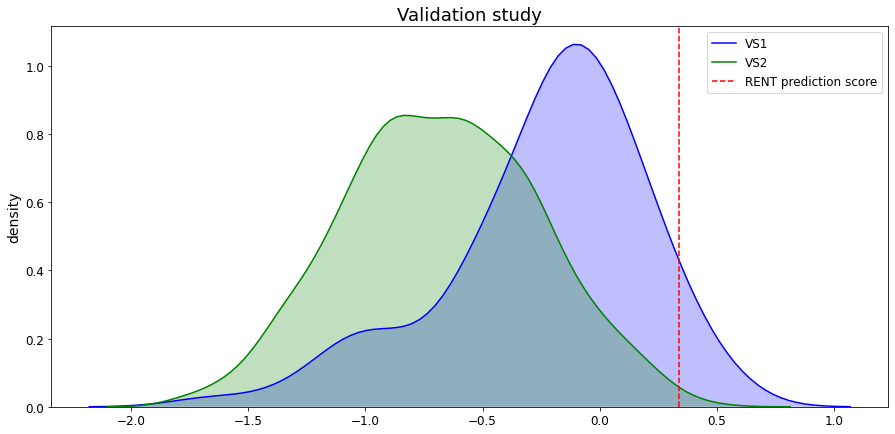

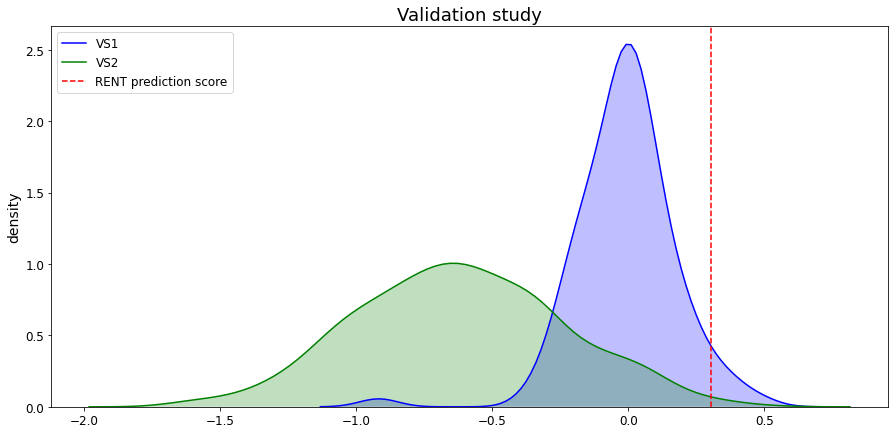

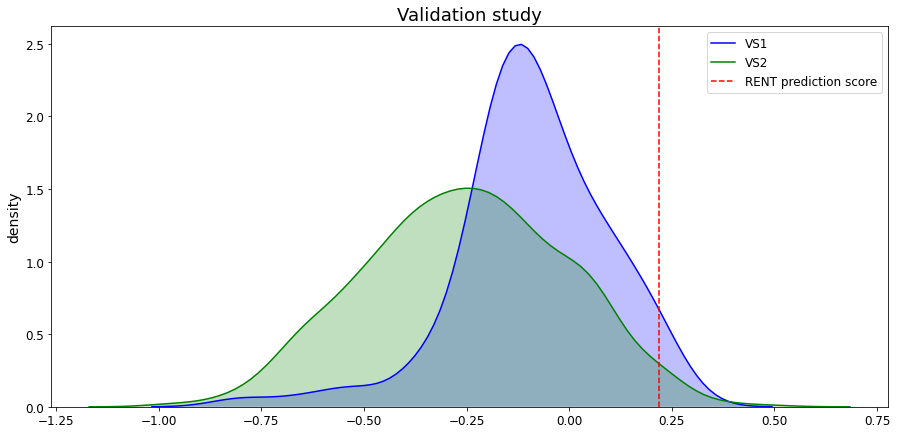

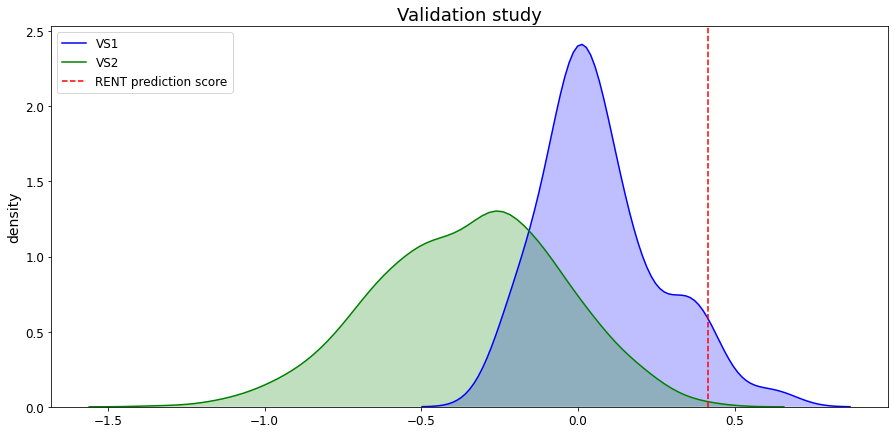

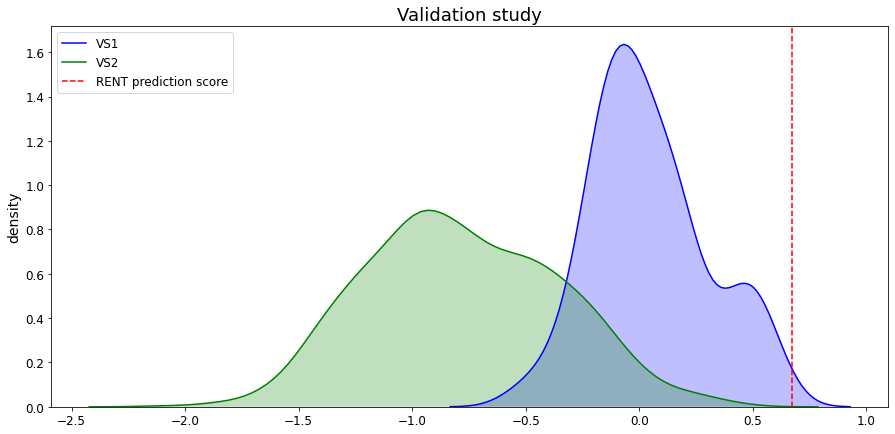

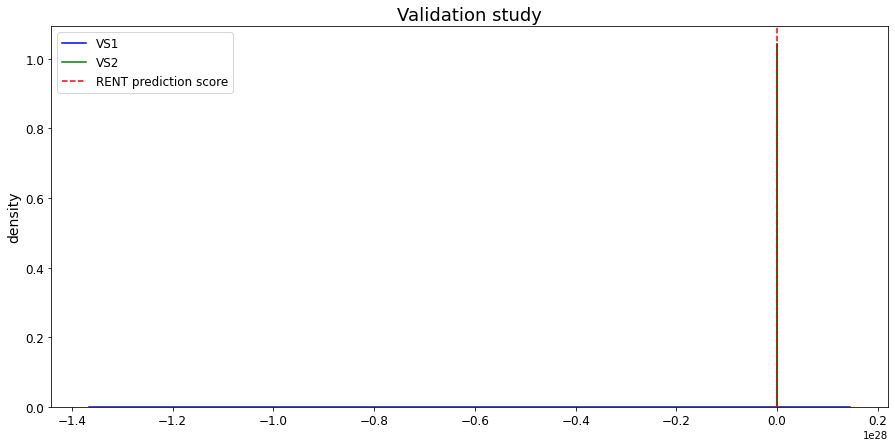

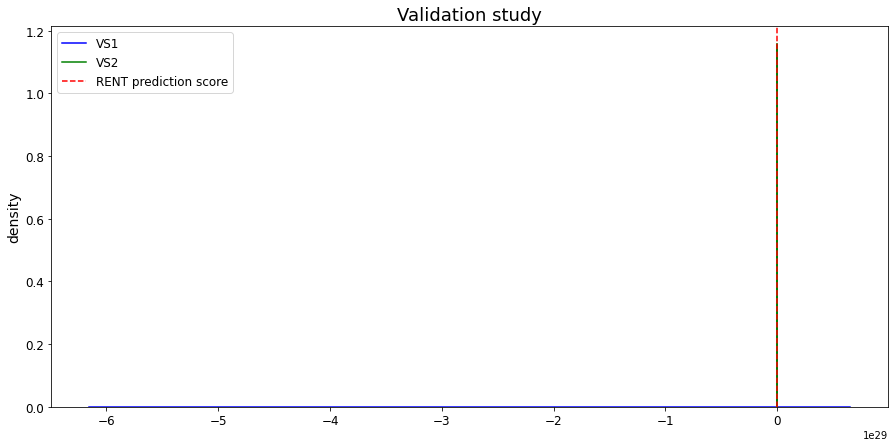

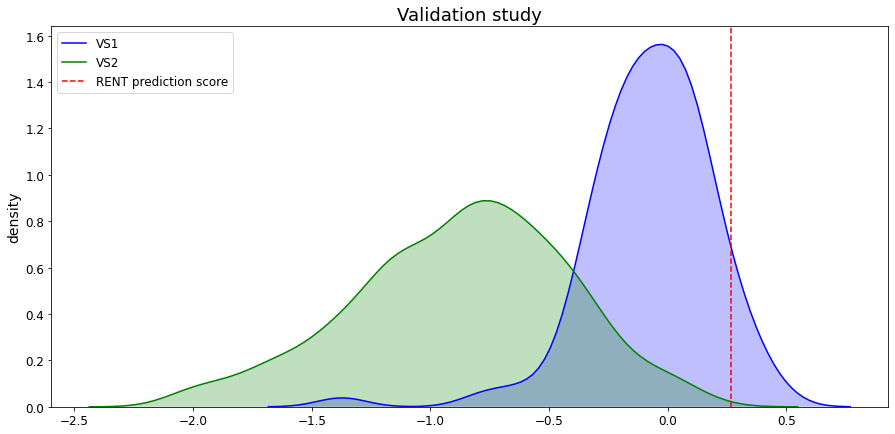

In [110]:
my_C_params = [0.1, 0.3, 0.5, 0.7, 1, 10]
my_l1_ratios = [0, 0.5, 1]

for train_index, test_index in rkf.split(first_block, boxcox_y):
    train_data, test_data = first_block.loc[train_index , : ] , first_block.loc[test_index,:]
    train_labels, test_labels = boxcox_y[train_index], boxcox_y[test_index]
    analysis =  RENT.RENT_Regression(data=train_data, 
                                target=train_labels, 
                                feat_names=first_block.columns, 
                                C= my_C_params, 
                                l1_ratios=my_l1_ratios,
                                autoEnetParSel=True,
                                poly='OFF',
                                testsize_range=(0.25,0.25),
                                K=700,
                                random_state=0,
                                verbose=1)

    analysis.train()
    selected_features = analysis.select_features(tau_1_cutoff=0.9, tau_2_cutoff=0.9, tau_3_cutoff=0.975)
    print('SELECTED FAETURES ARE : {}'.format(train_data.columns[selected_features]))
    
    # Scale the data accordingly
    sc = StandardScaler()
    train_data_1 = sc.fit_transform(train_data.iloc[:, selected_features])
    test_data_1 = sc.transform(test_data.iloc[:, selected_features])
    # Train model with 
    prediction_model = LinearRegression().fit(train_data_1, train_labels)
    print("R2: ", r2_score(test_labels, prediction_model.predict(test_data_1)))
    print("RMSEP: ", np.sqrt(mean_squared_error(test_labels, prediction_model.predict(test_data_1))))

    analysis.plot_validation_study(test_data, test_labels, num_drawings=100, num_permutations=1000, alpha=0.05)

- Table 5.12 in the thesis summarizes the above results.

### RENT feature selection on the second block

data dimension: (51, 20)  data type: <class 'pandas.core.frame.DataFrame'>
target dimension: (51,)
regularization parameters C: [0.1, 0.3, 0.5, 0.7, 1, 10]
elastic net l1_ratios: [0, 0.5, 1]
poly: OFF
number of models in ensemble: 700
random state: 0
verbose: 1
SELECTED FAETURES ARE : Index(['HMGLBN_<11 g/dL', 'LACTDHDR_> 2UNL', 'CGA2_Normal'], dtype='object')
R2:  -0.04057470706820743
RMSEP:  0.6903277868739894
mean VS1 -0.04542919145097623
VS1: p-value for average score from random feature drawing:  0.3955514195650312
VS1: heuristic p-value (how many scores are higher than the RENT score):  0.46
With a significancelevel of  0.05  H0 is accepted.
 
-----------------------------------------------------------
 
Mean VS2 -0.5321535050887574
VS2: p-value for score from permutation of test labels:  1.6200928517535416e-224
VS2: heuristic p-value (how many scores are higher than the RENT score):  1.6200928517535416e-224
With a significancelevel of  0.05  H0 is rejected.
data dimension: (51, 

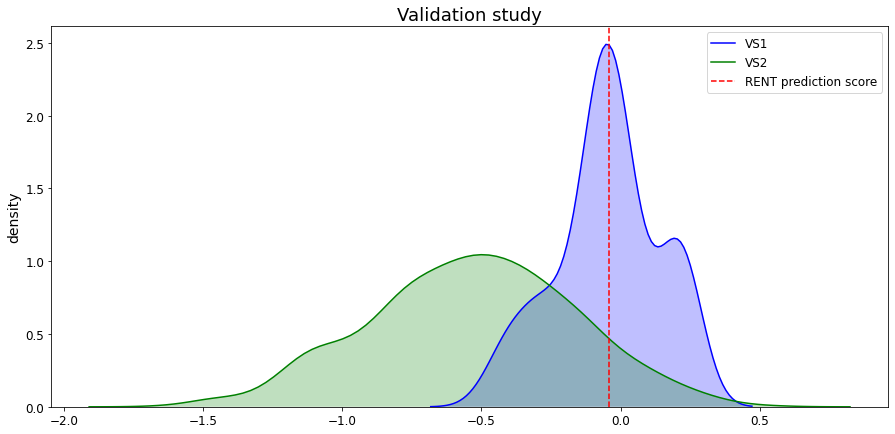

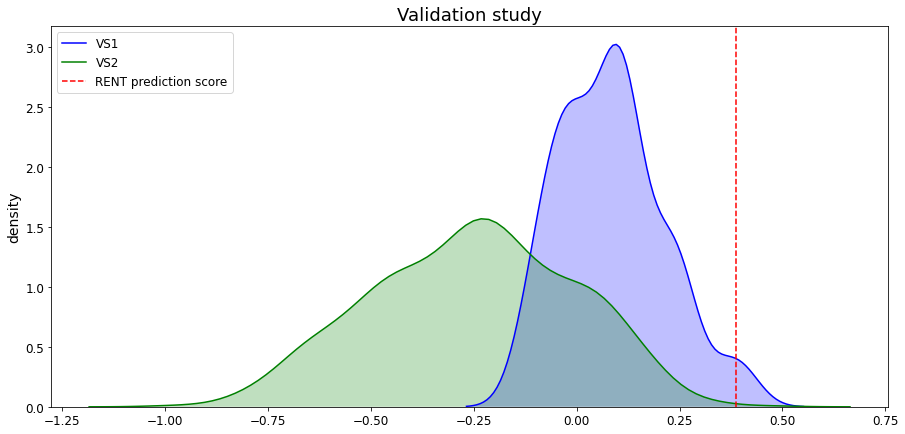

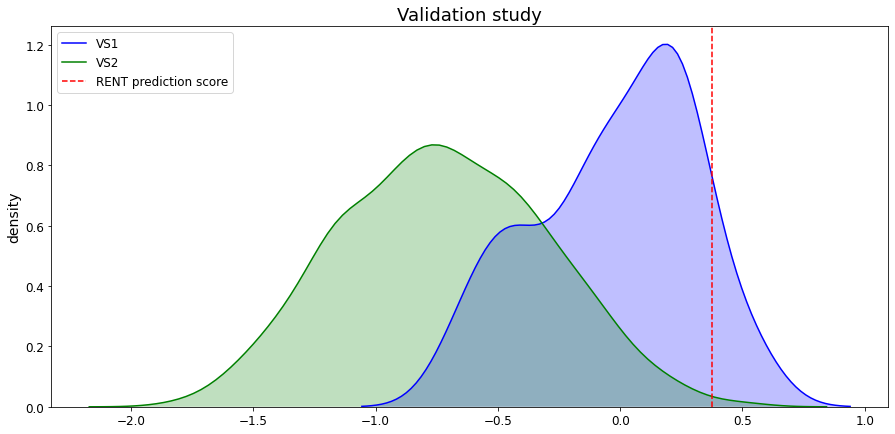

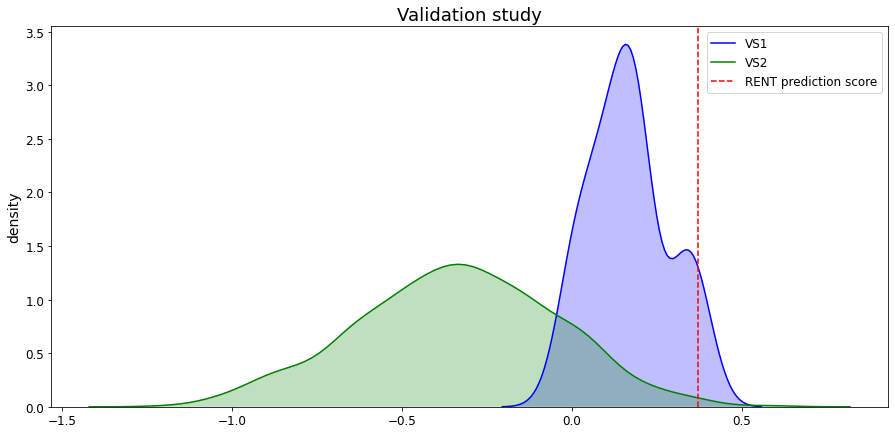

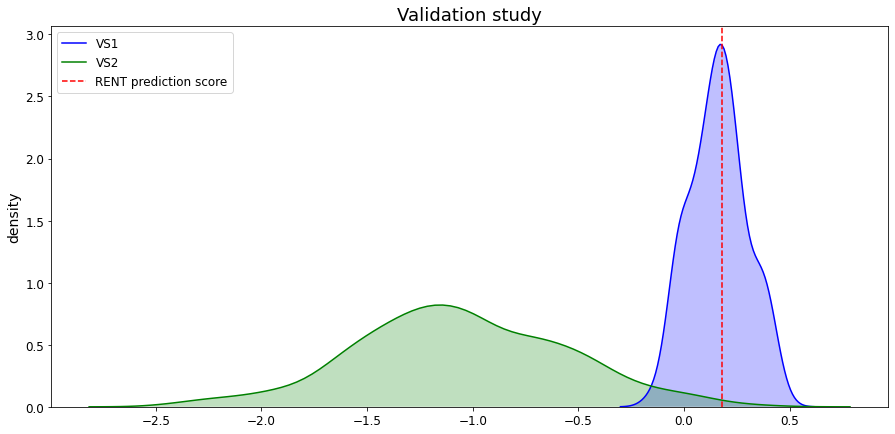

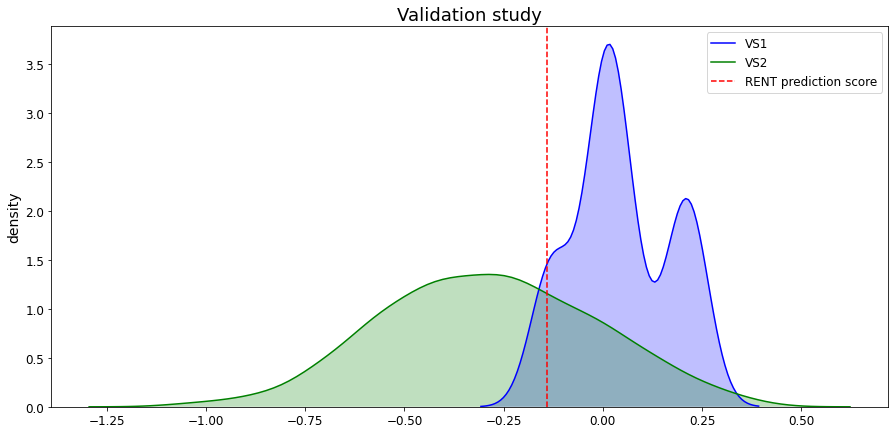

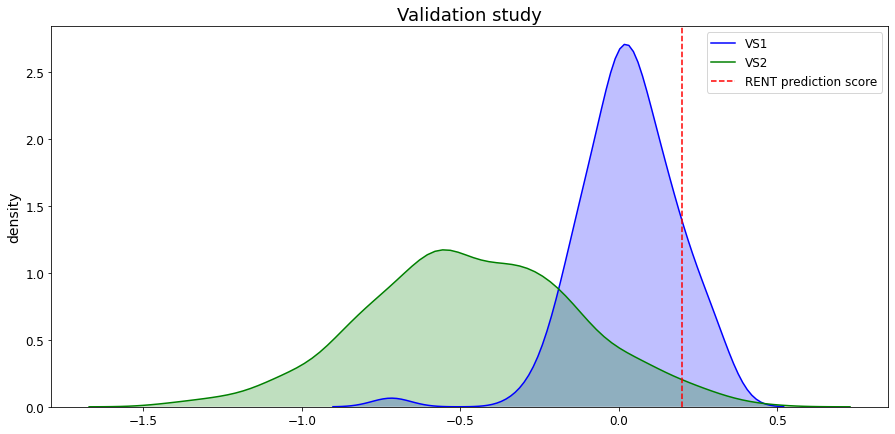

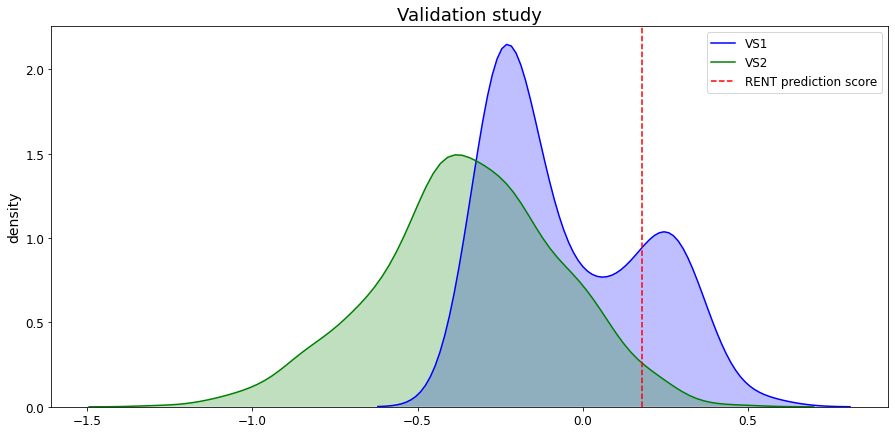

In [111]:
my_C_params = [0.1, 0.3, 0.5, 0.7, 1, 10]
my_l1_ratios = [0, 0.5, 1]

for train_index, test_index in rkf.split(second_block, boxcox_y):
    train_data, test_data = second_block.loc[train_index , : ] , second_block.loc[test_index,:]
    train_labels, test_labels = boxcox_y[train_index], boxcox_y[test_index]
    analysis =  RENT.RENT_Regression(data=train_data, 
                                target=train_labels, 
                                feat_names=second_block.columns, 
                                C= my_C_params, 
                                l1_ratios=my_l1_ratios,
                                autoEnetParSel=True,
                                poly='OFF',
                                testsize_range=(0.25,0.25),
                                K=700,
                                random_state=0,
                                verbose=1)

    analysis.train()
    selected_features = analysis.select_features(tau_1_cutoff=0.9, tau_2_cutoff=0.9, tau_3_cutoff=0.975)
    print('SELECTED FAETURES ARE : {}'.format(train_data.columns[selected_features]))
    # Scale the data accordingly
    sc = StandardScaler()
    train_data_1 = sc.fit_transform(train_data.iloc[:, selected_features])
    test_data_1 = sc.transform(test_data.iloc[:, selected_features])
    # Train model with 
    prediction_model = LinearRegression().fit(train_data_1, train_labels)
    print("R2: ", r2_score(test_labels, prediction_model.predict(test_data_1)))
    print("RMSEP: ", np.sqrt(mean_squared_error(test_labels, prediction_model.predict(test_data_1))))

    analysis.plot_validation_study(test_data, test_labels, num_drawings=100, num_permutations=1000, alpha=0.05)

- Table 5.13 in the thesis summarizes the above results.

# Prepare the csv files for muti-block analysis

In [112]:
block1 = first_block[['SURGMET','SMOKHAB_Smoker','CGA1_Negative','PERFSTAT_WHO 0','RESPONS1_Complete Response (CR)',
                     'RESPONS1_Progressive Disease (PD)','TIMETOTRM1']]
# These features are selected based on RENT results

In [113]:
block1.to_csv('block1.csv', header=True, index=False)

In [114]:
block2 = second_block[['CGA2_>Normal <= 2UNL','CGA2_Normal','HMGLBN_<11 g/dL','LACTDHDR_> 2UNL',
                      'PLATELTS_>400x10ˆ9/L','ALKPHSPH_>3 UNL','ALKPHSPH_Normal']]
# These features are selected based on RENT results

In [115]:
block2.to_csv('block2.csv', header=True, index=False)

In [116]:
boxcox_y = pd.DataFrame(boxcox_y)
boxcox_y.columns=['target']

In [117]:
boxcox_y.to_csv('target_box.csv', header=True, index=False)